In [286]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
path_casos = r"D:\pythonDSA\AbsoluteProject\20230803_Casos_e_obitos_ESP.CSV"

In [287]:
planilha_casos = pd.read_csv(path_casos, sep=';', lineterminator='\n')

_______________________________________________________________________________________________________________________________

## Item 1

In [288]:
valores = planilha_casos['Genero'].value_counts()
print(valores[['FEMININO', 'MASCULINO']])

FEMININO     3639077
MASCULINO    3006180
Name: Genero, dtype: int64


In [289]:
valores["FEMININO"] - valores["MASCULINO"]

632897

Considerando que todos os dados na planilha indicam que houve a ocorrência de Covid-19 no indivíduo, basta 
verificarmos quantos valores com a coluna 'Genero' são iguais à 'MASCULINO' ou 'FEMININO' para conseguir responder
o primeiro item. De acordo com a consulta, foram constatados 3.639.077 casos no gênero feminino e 3.006.180 no gênero
masculino.
Dessa forma, houveram 632897 casos a mais no gênero feminino em relação ao gênero masculino.

_______________________________________________________________________________________________________________________________

## Item 2 

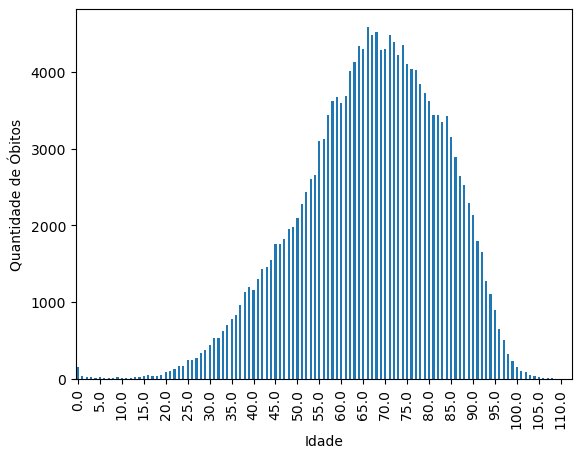

In [290]:
obitos = planilha_casos['Obito'] == 1 # Pegar quais dados constatam com óbito
# A lista anterior de True e False é passada como parâmetro para pegar apenas os dados necessários
obitos_por_idades = ((planilha_casos[obitos])['Idade'].value_counts()).sort_index() 

# Configurações do gráfico
obitos_por_idades.plot(kind='bar')
plt.xlabel('Idade')
plt.ylabel('Quantidade de Óbitos')
step_years = 5
plt.xticks(range(0, len(obitos_por_idades.index), step_years), obitos_por_idades.index[::step_years])
plt.show()

Primeiramente, eu selecionei todos os dados em que ocorreram óbitos. Esta linha irá retornar uma lista de True e False, dessa forma, eu conseguiria utilizá-la como índice para resgatar apenas os valores que possuem óbito. Assim, eu precisaria utilizar esta lista como um check_value para a coluna idades e, então, separá-las por ordem de idade.
Assim, eu adicionei um "step" de 5 anos para que o gráfico ficasse limpo visualmente e adicionei a função para chamar o gráfico.

_______________________________________________________________________________________________________________________________

## Item 3

In [291]:
funcao = lambda x: x.value_counts()
doencas_provaveis = {}
for i in planilha_casos.columns:
    if i not in ['Diagnostico_Covid19', 'Idade', 'Municipio', 'Obito', 'Genero', 'Data_Inicio_Sintomas']:
        doencas_provaveis[i] = planilha_casos[i].value_counts()['SIM']
doencas_provaveis

{'Asma': 16141,
 'Cardiopatia': 468680,
 'Diabetes': 311597,
 'Doenca_Hematologica': 4530,
 'Doenca_Hepatica': 4699,
 'Doenca_Neurologica': 23773,
 'Doenca Renal': 31976,
 'Imunodepressao': 38849,
 'Obesidade': 48663,
 'Outros_Fatores_De_Risco': 152256,
 'Pneumopatia': 20064,
 'Puérpera': 1684,
 'Síndrome_De_Down': 1449}

In [294]:
print(f"""A comorbidade com maior ocorrências em uma pessoa com Covid, segundo a base de dados, é: 
{max(doencas_provaveis.items(), key=lambda item: item[1])[0]}""")

A comorbidade com maior ocorrências de ser encontrada em uma pessoa com Covid é: 
Cardiopatia


Neste item, eu optei por utilizar um laço for já que havia algumas colunas que não poderiam ser contabilizados, como datas e idade. Assim, fiz a chamada de um dicionário para conseguir armazenar o nome e a incidência de "SIM" em cada coluna para todas as comorbidades pré-existentes. Após, chamei a função max e fiz com que a key a ser avaliada fosse o item 1 da lista que seria obtida ao utilizar o items(), ou seja, a quantidade de ocorrências para cada comorbidade.

_______________________________________________________________________________________________________________________________

## Item 4

In [273]:
planilha_estimativa = planilha_casos.copy()

In [274]:
doencas_preexistentes = ['Asma', 'Cardiopatia', 'Diabetes','Doenca_Hematologica', 'Doenca_Hepatica',
                       'Doenca_Neurologica', 'Doenca Renal',
                       'Imunodepressao', 'Obesidade',
                       'Outros_Fatores_De_Risco', 'Pneumopatia', 'Puérpera',
                       'Síndrome_De_Down']
planilha_estimativa[doencas_preexistentes] = planilha_casos[doencas_preexistentes].replace({'NÃO': 0, 'SIM': 1, 'IGNORADO': 0})
# Substituindo os valores para conseguir trabalhar no modelo

In [275]:
planilha_estimativa['Genero'] = planilha_estimativa['Genero'].map({'MASCULINO': 0, 'FEMININO': 1,'INDEFINIDO':2, 'IGNORADO':3})
genero_valores = planilha_estimativa['Genero'].median()
planilha_estimativa['Genero'] = planilha_estimativa['Genero'].fillna(genero_valores)


Passei todas as possibilidades de gênero possíveis para substituir pelos gêneros Strings para também conseguir
trabalhar no modelo, entretanto, realizei a média desses valores para ser capaz de preencher qualquer valor NaN
que possa existir no dataframe

In [276]:
planilha_estimativa['Masculino'] = (planilha_estimativa['Genero'] == 'MASCULINO').astype(int)
planilha_estimativa['Feminino'] = (planilha_estimativa['Genero'] == 'FEMININO').astype(int)
planilha_estimativa['Indefinido'] = (planilha_estimativa['Genero'] == 'INDEFINIDO').astype(int)
planilha_estimativa['Ignorado'] = (planilha_estimativa['Genero'] == 'IGNORADO').astype(int)


Neste parte eu transformei cada possibilidade de gênero em uma coluna no dataframe, assinalando 1 se o valor é 
igual ao gênero da coluna ou 0 se não

In [277]:
idade_valores = planilha_estimativa['Idade'].median()
planilha_estimativa['Idade'] = planilha_estimativa['Idade'].fillna(idade_valores)


Com as idades o trabalho foi menor, pois precisei apenas realizar a média e então preencher os valores vazios.

In [278]:
predict_colunas = ['Idade'] + ['Masculino', 'Feminino', 'Indefinido','Ignorado'] + doencas_preexistentes
X_planilha_estimativa = planilha_estimativa[predict_colunas].values
y_planilha_estimativa = planilha_estimativa['Obito'].values

Na linha acima, eu gerei dois tipos de valores (dataframe.values) que são aceitos pelo model

In [279]:
model = LogisticRegression(max_iter=planilha_estimativa.shape[0]) 
# Estava com problemas com o maximo de interações, então precisei aumentar o limite
model.fit(X_planilha_estimativa, y_planilha_estimativa)

LogisticRegression(max_iter=6648708)

Realizei uma logistic regression com o limite do tamanho do dataframe, apenas para garantir que todo o modelo pudesse ser gerado de forma fiel.

A PRÓXIMA LINHA É O LOCAL PARA REALIZAR INPUTS

In [295]:
idade = int(input("Digite a idade da pessoa: "))
print("""Digite o gênero da pessoa seguindo os parâmetros:
        M - gênero Masculino 
        F - gênero Feminino
        In - gênero Indefinido
        Ig - gênero Ignorado\n""")
flag = True
while flag:
    genero = input()
    if genero in ['M', 'F', 'In', 'Ig']:
        if genero == 'M':
            genero = [1, 0, 0, 0]
            flag = False
        elif genero == 'F':
            genero = [0, 1, 0, 0]
            flag = False
        elif genero == 'In':
            genero = [0, 0, 1, 0]
            flag = False
        elif genero == 'Ig':
            genero = [0, 0, 0, 1]
            flag = False
    else:
        print("Valor incorreto, digite novamente")

print("Assinale 0 para não e 1 para sim")
doencas_input = [int(input(f"A pessoa possui {i}? ")) for i in doencas_preexistentes]
dados_predicao = np.array([[idade] + genero + doencas_input])

Digite a idade da pessoa: 78
Digite o gênero da pessoa seguindo os parâmetros:
        M - gênero Masculino 
        F - gênero Feminino
        In - gênero Indefinido
        Ig - gênero Ignorado

F
Assinale 0 para não e 1 para sim
A pessoa possui Asma? 0
A pessoa possui Cardiopatia? 0
A pessoa possui Diabetes? 0
A pessoa possui Doenca_Hematologica? 0
A pessoa possui Doenca_Hepatica? 0
A pessoa possui Doenca_Neurologica? 0
A pessoa possui Doenca Renal? 0
A pessoa possui Imunodepressao? 0
A pessoa possui Obesidade? 0
A pessoa possui Outros_Fatores_De_Risco? 0
A pessoa possui Pneumopatia? 0
A pessoa possui Puérpera? 0
A pessoa possui Síndrome_De_Down? 0


Todos os valores já estão formatados para serem passados por uma predição no modelo, o que deixa maior a usabilidade para o usuário.

In [296]:
resultado_predicao = model.predict(dados_predicao)
print("Segundo a predição, a pessoa tem maior chance de:", "Óbito" if resultado_predicao == 1 else "Não óbito")

Segundo a predição, a pessoa tem maior chance de: Não óbito


In [297]:
probabilidades = model.predict_proba(dados_predicao)
probabilidade_obito = probabilidades[0, 1]

print(f"Probabilidade de óbito: {(probabilidade_obito*100):.2f} %")

Probabilidade de óbito: 6.81 %


Dessa forma, com a função predict_proba, é possível dizer a porcentagem que, segundo a base de dados, um indivíduo com X características possui de morrer ao ser infectado de Covid. 